In [1]:
# Add DEVENV_PATH to the path so that we can import the modules
import sys
from os import getenv

import pendulum
sys.path.append(getenv("DEVENV_ROOT"))

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns

from entrypoint import load_gin
load_gin("ingest-kafka", test=False)
import greenflow.analysis as an
from greenflow.utils import convert_to_mib

cutoff_begin = "2024-12-16T03:15:35.626996+01:00"
# cutoff_end = '2025-02-12T00:07:45.003699+01:00'
cutoff_end = pendulum.now().to_iso8601_string()

load_gin(exp_name="ingest-kafka", test=False)
# cutoff_end

from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime
import pandas as pd
import pendulum
from tinydb import TinyDB, Query
from os import getenv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with custom encoding error
handler: 'OutStream' object has no attribute 'reconfigure'


In [2]:
import greenflow.analysis as an

df = an.full_analytical_pipeline_nocache(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    cluster=".*",
    # cluster="taurus",
    replicationFactor=3,
    partitions=1,
    messageSize=32,
    producer_instances=10,
    consumer_instances=10,
    type="baseline",
    # type=".*",
)
an.create_qgrid_widget(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [3]:
# experiments = an.get_experiments()
# redpanda_kafka_data = an.filter_experiments(
#     experiments,
#     an.interest(cluster="ovhnvme", type="memImpact"),
#     cutoff_begin=cutoff_begin,
#     cutoff_end=cutoff_end,
# )
# df = df[df["load"] != 0]
df = df.dropna()
df = df[df["load"] != 50000]
df = df[df["load"] == 10**9]
df = df[df["observed_throughput"] != 100]
df = df[df["producer_instances"] != 1]
df = df[df["broker_cpu"] == 8]
df = df[df["broker_mem"] == "16Gi"]
# df = df[df["durationSeconds"] == 100]
# df = df[df["partitions"] > 15]
# df["unit_power"] = df["average_power"] / df["num_broker_nodes"]

# df = df[df["partitions"] != 1]
# df = df[df["producer_instances"] != 1]
# df = df[df["partitions"] >= 100]
# df = df[df["broker_replicas"] == 3]
df = df[df['partitions'] == df['broker_replicas'] * 10]

an.create_qgrid_widget(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

ValueError: Axes(0.125,0.11;0.775x0.77) has no legend attached.

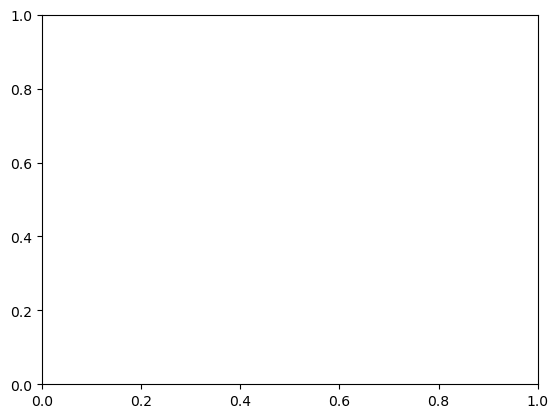

In [4]:
kafka = df[df["exp_name"] == "ingest-kafka"]
redpanda = df[df["exp_name"] == "ingest-redpanda"]
x = "throughput_MBps"
y = "adjusted_power"
ax = sns.scatterplot(
    data=kafka,
    x=x,
    y=y,
    hue="cluster",
    style="broker_replicas",
    # size="broker_replicas",
    # sizes=(50, 200)
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# sns.FacetGrid(df, col="cluster", hue="exp_name", col_wrap=3).map(
#     sns.scatterplot, "throughput_MBps", "adjusted_power"
# ).add_legend()

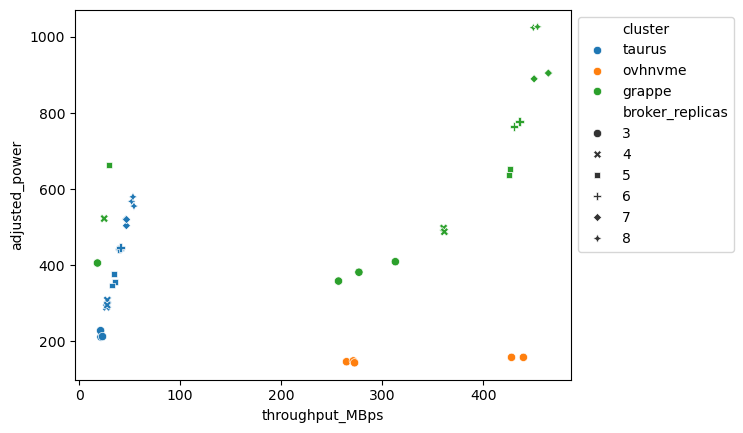

In [ ]:
ax = sns.scatterplot(
    data=redpanda,
    x=x,
    y=y,
    hue="cluster",
    style="broker_replicas",
    # size="broker_replicas",
    # sizes=(50, 200)
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<Axes: xlabel='observed_throughput', ylabel='adjusted_power'>

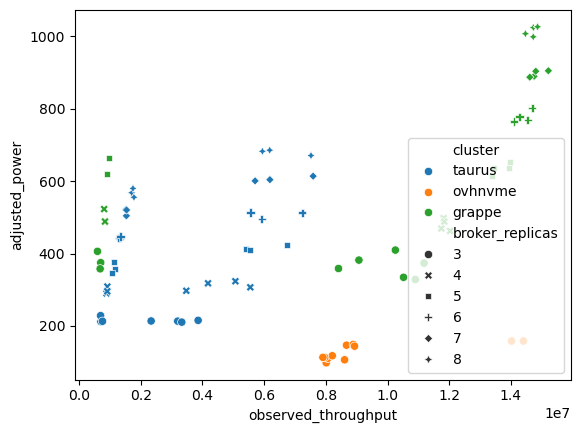

In [ ]:
sns.scatterplot(data=df, x="observed_throughput", y="adjusted_power", hue="cluster", style="broker_replicas")